![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [20]:
# Ignorar alertas
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [22]:
data['M_Camry'] = pd.factorize(data.M_Camry)[0]
data['M_Camry4dr'] = pd.factorize(data.M_Camry4dr)[0]
data['M_CamryBase'] = pd.factorize(data.M_CamryBase)[0]
data['M_CamryL'] = pd.factorize(data.M_CamryL)[0]
data['M_CamryLE'] = pd.factorize(data.M_CamryLE)[0]
data['M_CamrySE'] = pd.factorize(data.M_CamrySE)[0]
data['M_CamryXLE'] = pd.factorize(data.M_CamryXLE)[0]
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,0,0,0,0
11,13995,2014,39972,0,0,0,1,1,0,0
167,17941,2016,18989,0,0,0,1,0,1,0
225,12493,2014,51330,0,0,0,0,0,0,0
270,7994,2007,116065,0,1,0,1,0,0,0


In [23]:
data.describe()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
count,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395,0.056313,0.158456,0.012292,0.951787,0.236494,0.376370,0.111863
std,3922.420961,3.116585,36791.736601,0.230535,0.365186,0.110189,0.214227,0.424949,0.484498,0.315213
min,5002.000000,1998.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11999.000000,2012.000000,26461.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,15000.000000,2014.000000,41680.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,16999.000000,2016.000000,71355.500000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,32444.000000,2018.000000,232658.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  int64
 4   M_Camry4dr   10495 non-null  int64
 5   M_CamryBase  10495 non-null  int64
 6   M_CamryL     10495 non-null  int64
 7   M_CamryLE    10495 non-null  int64
 8   M_CamrySE    10495 non-null  int64
 9   M_CamryXLE   10495 non-null  int64
dtypes: int64(10)
memory usage: 901.9 KB


In [25]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [26]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [28]:
# Librerías utilizadas para regresión de árboles
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [29]:
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [30]:
def var(y):
    """Calcula la varianza de los valores en y."""
    return y.var() if len(y) > 0 else 0

In [31]:
def var_impurity(X_col, y, split):
    """Calcula la reducción de impureza al hacer un split en X_col."""
    filter_l = X_col < split
    y_l, y_r = y[filter_l], y[~filter_l]
    
    n_l, n_r = len(y_l), len(y_r)
    if n_l == 0 or n_r == 0:
        return 0  # Evita splits innecesarios
    
    impurity_reduction = var(y) - (n_l / (n_l + n_r) * var(y_l) + n_r / (n_l + n_r) * var(y_r))
    return impurity_reduction

In [32]:
def best_split(X, y, num_pct=10):
    """Encuentra la mejor división basada en la máxima reducción de impureza."""
    best = {'feature': None, 'split': None, 'gain': -np.inf}
    
    for j in range(X.shape[1]):
        unique_values = np.percentile(X.iloc[:, j], np.linspace(0, 100, num_pct + 2)[1:-1])
        unique_values = np.unique(unique_values)
        
        for split in unique_values:
            gain = var_impurity(X.iloc[:, j], y, split)
            if gain > best['gain']:
                best = {'feature': j, 'split': split, 'gain': gain}
    
    return best['feature'], best['split'], best['gain']

In [33]:
j, split, gain = best_split(X_train, y_train, 2)
j, split, gain

(0, np.float64(2014.0), np.float64(8772645.83591998))

In [34]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    """Construye el árbol de decisión de manera recursiva."""
    if len(y) == 1:
        return {'y_pred': y.iloc[0], 'y_prob': 0.5, 'level': level, 'split': None, 'n_samples': 1, 'gain': 0}
    
    j, split, gain = best_split(X, y, num_pct)
    
    # Condiciones de parada
    if gain < min_gain or (max_depth is not None and level >= max_depth):
        return {'y_pred': y.mean(), 'y_prob': (y.sum() + 1) / (len(y) + 2), 'level': level, 'split': None, 'n_samples': len(y), 'gain': gain}
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l, X_r, y_r = X[filter_l], y[filter_l], X[~filter_l], y[~filter_l]
    
    return {
        'y_pred': y.mean(),
        'y_prob': (y.sum() + 1) / (len(y) + 2),
        'level': level,
        'split': (j, split),
        'n_samples': len(y),
        'gain': gain,
        'sl': tree_grow(X_l, y_l, level + 1, min_gain, max_depth, num_pct),
        'sr': tree_grow(X_r, y_r, level + 1, min_gain, max_depth, num_pct)
    }

In [35]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': np.float64(14527.187882235812),
 'y_prob': np.float64(14523.0568747334),
 'level': 0,
 'split': (0, np.float64(2014.0)),
 'n_samples': 7031,
 'gain': np.float64(8772645.83591998),
 'sl': {'y_pred': np.float64(10222.385568835769),
  'y_prob': np.float64(10213.343653250775),
  'level': 1,
  'split': (0, np.float64(2012.0)),
  'n_samples': 2259,
  'gain': np.float64(3917591.051603822),
  'sl': {'y_pred': np.float64(8765.206825938567),
   'y_prob': np.float64(8753.257668711656),
   'level': 2,
   'split': (0, np.float64(2010.0)),
   'n_samples': 1465,
   'gain': np.float64(1115395.187766428),
   'sl': {'y_pred': np.float64(7923.032366071428),
    'y_prob': np.float64(7905.387527839644),
    'level': 3,
    'split': None,
    'n_samples': 896,
    'gain': np.float64(688101.0385855744)},
   'sr': {'y_pred': np.float64(10091.37258347979),
    'y_prob': np.float64(10056.028021015762),
    'level': 3,
    'split': None,
    'n_samples': 569,
    'gain': np.float64(899911.1494704406)}

In [36]:
def tree_predict(X, tree, proba=False):
    """Predice valores para X usando el árbol de decisión."""
    predictions = np.empty(X.shape[0])
    
    for i in range(len(X)):
        node = tree
        while node['split'] is not None:
            feature, split = node['split']
            node = node['sl'] if X.iloc[i, feature] < split else node['sr']
        predictions[i] = node['y_prob'] if proba else node['y_pred']
    
    return predictions

In [37]:
# Ejecución de función tree_predict
yPredict_Tree = tree_predict(X_test, tree)

In [38]:
MSETREE = np.average(np.square(yPredict_Tree-y_test))
r2Tree = r2_score(y_test, yPredict_Tree)

# Mostramos los resultados
print(f'MSE: {MSETREE:.2f}')
print(f'RMSE: {np.sqrt(MSETREE):.2f}')
print(f"R² Score: {r2Tree:.3f}")

MSE: 3595738.59
RMSE: 1896.24
R² Score: 0.760


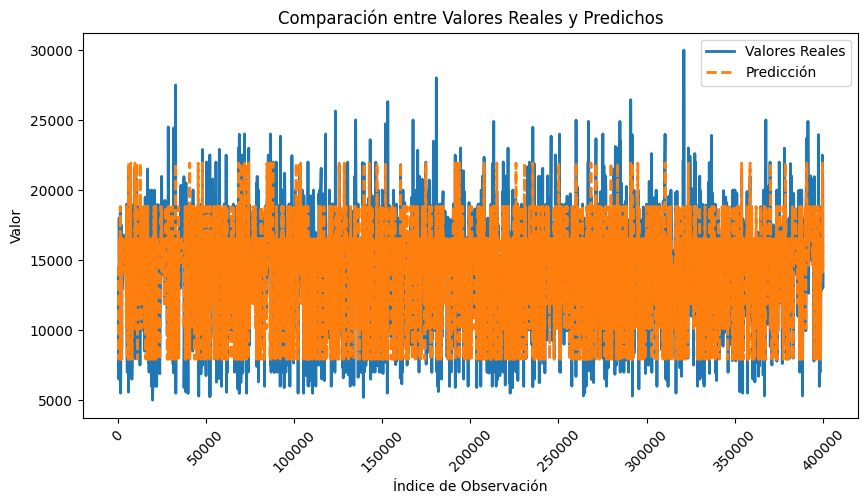

In [39]:
graf = pd.DataFrame({"real": y_test, "predicho": yPredict_Tree})

plt.figure(figsize=(10, 5))
sns.lineplot(data=graf, x=graf.index, y="real", label="Valores Reales", linewidth=2)
sns.lineplot(data=graf, x=graf.index, y="predicho", label="Predicción", linestyle="dashed", linewidth=2)

plt.xticks(rotation=45)  # Mejora la legibilidad del eje x si es una fecha/hora
plt.xlabel("Índice de Observación")
plt.ylabel("Valor")
plt.title("Comparación entre Valores Reales y Predichos")
plt.legend()
plt.show()

In [40]:
def mse_def(y):
    return ((y - y.mean())**2).mean() if len(y) > 0 else 0

In [41]:
def mse_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l, y_r = y[filter_l], y[~filter_l]
    
    n_l, n_r = y_l.shape[0], y_r.shape[0]
    if n_l == 0 or n_r == 0:
        return 0  # Evita splits innecesarios
    
    mse_y = mse_def(y)
    mse_l = mse_def(y_l)
    mse_r = mse_def(y_r)
    
    mse_impurity_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    
    return mse_impurity_


In [42]:
def best_split(X, y, num_pct=10):
    """Encuentra la mejor división basada en la reducción de MSE."""
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.linspace(0, 100, num_pct + 2)[1:-1])
        splits = np.unique(splits)
        
        for split in splits:
            gain = mse_impurity(X.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [43]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        return dict(y_pred=y.mean(), level=level, split=None, n_samples=1, gain=0)
    
    # Obtener mejor split
    j, split, gain = best_split(X, y, num_pct)

    # Definir valores de predicción
    y_pred = y.mean()
    
    # Construir nodo
    tree = dict(y_pred=y_pred, level=level, split=None, n_samples=X.shape[0], gain=gain)

    # Criterios de parada
    if gain < min_gain or (max_depth is not None and level >= max_depth):
        return tree

    # Si hay una buena división, actualizar el nodo y continuar con hijos
    tree['split'] = [j, split]
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain, max_depth, num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain, max_depth, num_pct)

    return tree


In [44]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': np.float64(14527.187882235812),
 'level': 0,
 'split': [0, np.float64(2014.0)],
 'n_samples': 7031,
 'gain': np.float64(8772476.647294518),
 'sl': {'y_pred': np.float64(10222.385568835769),
  'level': 1,
  'split': [0, np.float64(2012.0)],
  'n_samples': 2259,
  'gain': np.float64(3917804.643603149),
  'sl': {'y_pred': np.float64(8765.206825938567),
   'level': 2,
   'split': [0, np.float64(2010.0)],
   'n_samples': 1465,
   'gain': np.float64(1116862.9305515732),
   'sl': {'y_pred': np.float64(7923.032366071428),
    'level': 3,
    'split': None,
    'n_samples': 896,
    'gain': np.float64(690447.555451347)},
   'sr': {'y_pred': np.float64(10091.37258347979),
    'level': 3,
    'split': None,
    'n_samples': 569,
    'gain': np.float64(902715.0324459565)}},
  'sr': {'y_pred': np.float64(12911.008816120906),
   'level': 2,
   'split': [1, np.float64(65336.9090909091)],
   'n_samples': 794,
   'gain': np.float64(1263752.6859777318),
   'sl': {'y_pred': np.float64(14142.18

In [45]:
def tree_predict(X, tree):
    predicted = np.ones(X.shape[0])

    # Si el nodo es terminal, devolver la predicción media almacenada
    if 'split' not in tree or tree['split'] == -1 or tree['split'] is None:
        return np.full(X.shape[0], tree['y_pred'])  # Devuelve la predicción promedio del nodo
    
    # De lo contrario, continuar dividiendo
    j, split = tree['split']
    filter_l = X.iloc[:, j] < split
    X_l = X.loc[filter_l]
    X_r = X.loc[~filter_l]

    if X_l.shape[0] > 0:
        predicted[filter_l] = tree_predict(X_l, tree['sl'])
    if X_r.shape[0] > 0:
        predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [46]:
# Ejecución de función tree_predict
yPredict_Tree = tree_predict(X_test, tree)

In [47]:
MSETREE = np.average(np.square(yPredict_Tree-y_test))
r2Tree = r2_score(y_test, yPredict_Tree)

# Mostramos los resultados
print(f'MSE: {MSETREE:.2f}')
print(f'RMSE: {np.sqrt(MSETREE):.2f}')
print(f"R² Score: {r2Tree:.3f}")

MSE: 3595738.59
RMSE: 1896.24
R² Score: 0.760


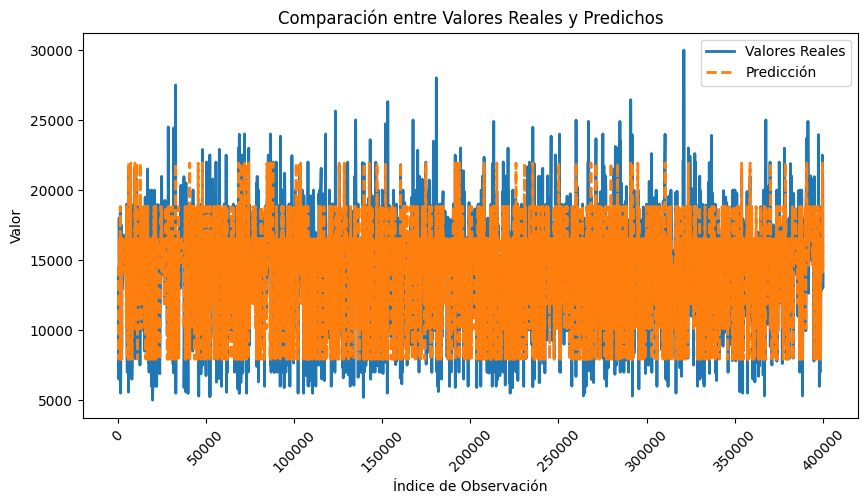

In [48]:
graf = pd.DataFrame({"real": y_test, "predicho": yPredict_Tree})

plt.figure(figsize=(10, 5))
sns.lineplot(data=graf, x=graf.index, y="real", label="Valores Reales", linewidth=2)
sns.lineplot(data=graf, x=graf.index, y="predicho", label="Predicción", linestyle="dashed", linewidth=2)

plt.xticks(rotation=45)  # Mejora la legibilidad del eje x si es una fecha/hora
plt.xlabel("Índice de Observación")
plt.ylabel("Valor")
plt.title("Comparación entre Valores Reales y Predichos")
plt.legend()
plt.show()

In [49]:
from sklearn.model_selection import KFold

def evaluate_tree_cv(X, y, k=5, max_depth=None, min_gain=0.001, num_pct=10, random_state=0):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)

    mse_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        tree = tree_grow(X_train, y_train, max_depth=max_depth, min_gain=min_gain, num_pct=num_pct)
        y_pred = tree_predict(X_test, tree)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_scores.append(mse)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

    results = {
        "MSE": np.mean(mse_scores),
        "RMSE": np.mean(rmse_scores),
        "MAE": np.mean(mae_scores),
        "R2": np.mean(r2_scores)
    }

    return results


In [50]:
results = evaluate_tree_cv(X, y, k=5, max_depth=5, min_gain=0.001, num_pct=10, random_state=0)
print("Evaluación promedio con validación cruzada:")
for metric, score in results.items():
    print(f"{metric}: {score:.3f}")


Evaluación promedio con validación cruzada:
MSE: 2818182.488
RMSE: 1678.532
MAE: 1244.951
R2: 0.817


In [51]:
# Inicializar lista para guardar métricas
mse_list, rmse_list, mae_list, r2_list = [], [], [], []

# Definir el número de folds
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Loop manual por cada fold
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenar tu árbol de regresión manual
    tree = tree_grow(X_train, y_train, max_depth=5, min_gain=0.001, num_pct=10)
    
    # Predicción
    y_pred = tree_predict(X_test, tree)

    # Métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f"\nFold {fold + 1}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2:   {r2:.4f}")

# Mostrar promedio final
print("\n--- Resultados promedio ---")
print(f"MSE promedio:  {np.mean(mse_list):.4f}")
print(f"RMSE promedio: {np.mean(rmse_list):.4f}")
print(f"MAE promedio:  {np.mean(mae_list):.4f}")
print(f"R2 promedio:   {np.mean(r2_list):.4f}")



Fold 1
MSE:  2885043.1241
RMSE: 1698.5415
MAE:  1235.0360
R2:   0.8111

Fold 2
MSE:  2707237.7084
RMSE: 1645.3686
MAE:  1240.6979
R2:   0.8182

Fold 3
MSE:  2956204.4318
RMSE: 1719.3616
MAE:  1270.4189
R2:   0.8083

Fold 4
MSE:  2763225.8051
RMSE: 1662.2953
MAE:  1236.7852
R2:   0.8200

Fold 5
MSE:  2779201.3723
RMSE: 1667.0937
MAE:  1241.8181
R2:   0.8259

--- Resultados promedio ---
MSE promedio:  2818182.4883
RMSE promedio: 1678.5321
MAE promedio:  1244.9512
R2 promedio:   0.8167


In [52]:
modelos = []
MSE = []
RMSE = []
MAE = []
R2 = []
# Guardar resultados en listas
modelos.append("Manual Tree")
MSE.append(np.mean(mse_list))
RMSE.append(np.mean(rmse_list))
MAE.append(np.mean(mae_list))
R2.append(np.mean(r2_list))

In [53]:
# Reestablecer datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [115]:
# Librerías utilizadas para ensamblajes Bagging
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [116]:
np.random.seed(42)                   # Fijamos la semilla para reproducibilidad
n_trees = 10                         # Puedes incrementar a 100 si deseas mayor robustez

predictions_train = []
predictions_test = []
trees = []

print("MODELADO BAGGING MANUAL CON " + str(n_trees) + " ÁRBOLES")

for i in range(n_trees):
    # Muestra bootstrap
    bootstrap_idx = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
    X_bootstrap = X_train.iloc[bootstrap_idx]
    y_bootstrap = y_train.iloc[bootstrap_idx]
    
    # Modelo
    tree = DecisionTreeRegressor(
        max_depth=max_depth,          # Asegúrate de haber definido esta variable antes
        max_features=max_features,    # Igual aquí
        random_state=i
    )
    tree.fit(X_bootstrap, y_bootstrap)
    trees.append(tree)

    # Predicciones
    predictions_train.append(tree.predict(X_train))
    predictions_test.append(tree.predict(X_test))

# Promedio de predicciones
y_train_bgm = np.mean(predictions_train, axis=0)
y_test_bgm = np.mean(predictions_test, axis=0)

# Evaluación del modelo TEST
MSE_bgm = mean_squared_error(y_test, y_test_bgm)
RMSE_bgm = np.sqrt(MSE_bgm)
MAE_bgm = mean_absolute_error(y_test, y_test_bgm)
r2_bgm = r2_score(y_test, y_test_bgm)

# Impresión de resultados
print("\n EVALUACIÓN DEL MODELO DE BAGGING MANUAL")

print("\n Conjunto de Prueba:")
print(f"MSE: {MSE_bgm:.2f}")
print(f"RMSE: {RMSE_bgm:.2f}")
print(f"MAE: {MAE_bgm:.2f}")
print(f"R2: {R2_bgm:.4f}")


MODELADO BAGGING MANUAL CON 10 ÁRBOLES

 EVALUACIÓN DEL MODELO DE BAGGING MANUAL

 Conjunto de Prueba:
MSE: 3256729.80
RMSE: 1804.64
MAE: 1357.54
R2: 0.7825


**El modelo bagging con 10 árboles de regresión y parámetros por defecto.** <br>
<p style="text-align: justify;">
El modelo de ensamble Baggin con uso de 10 árboles <br>
En este caso mejora ligeramente el poder predictivo del modelo con respecto al modelo de árbol de decisión <br>
Se presenta un valor de RMSE (Root Mean Squared Error) de 1804.64, esto indica que el precio predicho de los automóviles puede variar por el orden de 1804 Dólares, valor considerablemente peor con respecto al árbol de decisión <br>
El valor obtenido de R2 de 0.7825, indica que este modelo puede predcir correctamente aproximadamente el 78% de los datos <br>
Estos resultados pueden deberse al número limitado de árboles considerados, su profundidad o ausencia de parámetros de aletoriedad (max_features)

**Recomendaciones** <br>
<p style="text-align: justify;">
Aumentar el número de árboles con el fin de reducir la varianza <br>
Definir max_features, que podrían ayudar a mejorar el poder de generalización <br>

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [94]:
# Número de características
n_features = X_train.shape[1]
max_features_log = int(np.log(n_features))

# Entrenamiento del modelo con sklearn
bagging_model_log = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features_log,
    random_state=42
)
bagging_model_log.fit(X_train, y_train)

# Predicciones
y_train_bgl = bagging_model_log.predict(X_train)
y_test_bgl = bagging_model_log.predict(X_test)

# Evaluación del modelo de Bagging con librería
MSE_bgl = mean_squared_error(y_train, y_train_bgl)
RMSE_bgl = np.sqrt(MSE_bgl)
MAE_bgl = mean_absolute_error(y_train, y_train_bgl)
r2_bgl = r2_score(y_train, y_train_bgl)

print("\nEVALUACIÓN DEL MODELO DE BAGGING LIBRERÍA CON RESTRICCIONES \n")
print(n_features, "variables predictoreas utilizadas")
print(max_features_log, "variables seleccionadas para entrenar el árbol")
print(f"MSE: {MSE_bgl:.2f}")
print(f"RMSE: {RMSE_bgl:.2f}")
print(f"MAE: {MAE_bgl:.2f}")
print(f"R2: {r2_bgl:.4f}")


EVALUACIÓN DEL MODELO DE BAGGING LIBRERÍA CON RESTRICCIONES 

9 variables predictoreas utilizadas
2 variables seleccionadas para entrenar el árbol
MSE: 7843390.87
RMSE: 2800.61
MAE: 2177.13
R2: 0.4967


**El modelo bagging con 10 árboles de regresión y parámetros max_features = log(features).** <br>
<p style="text-align: justify;">
A cambio de usar todas las variables este modelo usa 9 variables, provenientes del cálculo condicional establecido, así mismo este modelo utiliza 2 de las 9 variables disponibles para el entrenamiento de cada árbol. 
Esta limitación aumenta la diversidad entre árboles, ya que cada árbol tiene un subcojunto diferente de variables.
Para el caso, esta limitación de variables hace que el poder predictivo de cada árbol individual sea muy limitado, reduciendo considerablemente el rendimiento del modelo

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [57]:
# Celda 4


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [58]:
# Celda 5


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [67]:
# Librerías utilizadas para Ensamblajes Xtreme Gradient Boosting
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


In [62]:
# Definición de modelo XGBRegressor
XGBReg = XGBRegressor()
XGBReg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [73]:
# Entrenamiento (fit) y desempeño del modelo XGBRegressor
XGBReg.fit(X_train, y_train)
y_pred = XGBReg.predict(X_test)

# Evaluación del modelo
MSE_XGBReg = mean_squared_error(y_test, y_pred)
RMSE_XGBReg = np.sqrt(mean_squared_error(y_test, y_pred))
MAE_XGBReg = mean_absolute_error(y_test, y_pred)
R2_XGBReg = r2_score(y_test, y_pred)

In [64]:
# Resultados
print('MAE: ', f'{MAE_XGBReg:.4f}')
print('RMSE: ', f'{RMSE_XGBReg:.4f}')
print('R2: ', f'{R2_XGBReg:.4f}')

MAE:  1158.1359
RMSE:  1557.9964
R2:  0.8379


**Comentarios Sobre el Desempeño del Modelo** <br>
<p style="text-align: justify;">
El modelo XGBoost presenta un buen desempeño general. El coeficiente $R^2$ = 0.8315 indica que el modelo explica más del 83% de la varianza en los datos de test, lo cual es un buen resultado en problemas de regresión. El MAE (1185) sugiere que el modelo se desvía en promedio 1185 unidades del valor real, mientras que el RMSE (1605) indica que hay algunos errores más grandes.<p>
<p style="text-align: justify;">
A continuación, se presenta un gráfico de dispersión entre los valores predichos y valores reales del modelo así como una interpretación de la misma:<p>

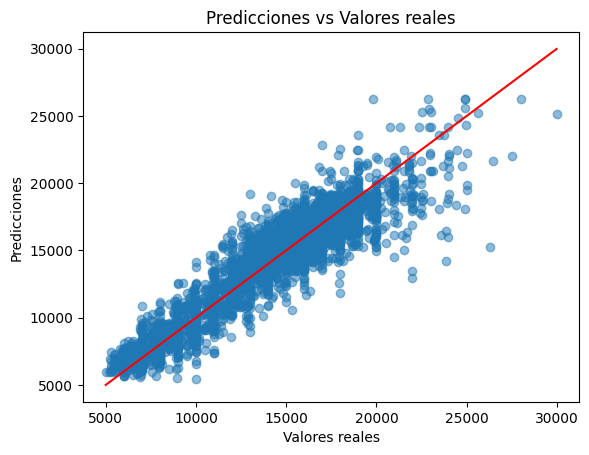

In [65]:
# Gráfica de dispersión entre valores reales y predicciones
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores reales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()

<p style="text-align: justify;">
El gráfico de dispersión de predicciones vs valores reales muestra una correlación positiva. La línea roja representa las predicciones ideales, es decir el caso donde y_test = y_pred en todos los puntos. Como se observa en la gráfica, la mayoría de los puntos están cercanos a esta línea, lo que indica que el modelo realiza predicciones correctas. Se observa cierta dispersión creciente a medida que aumentan los valores de y_test, lo que podría indicar que el modelo tiene más dificultad en predecir los valores extremos (posiblemente debido a outliers o a una varianza mayor en esos rangos). En general, la forma alineada de los puntos con la línea roja indica un buen ajuste del modelo, lo cual es soportado por las métricas de desempeño. <p>

**Recomendaciones**
<p style="text-align: justify;">
Como recomendación, se sugiere aplicar un método de calibración de hiperparámetros con validación cruzada, como por ejemplo GridSearchCV o RandomizedSearchCV. Esto permitiría encontrar combinaciones óptimas de parámetros relevantes —como learning_rate— mejorando el desempeño del modelo. Además, el uso de validación cruzada contribuye a reducir el riesgo de sobreajuste (overfitting), al garantizar que el modelo generalice adecuadamente sobre distintos subconjuntos de datos.<p>

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [68]:
# Calibracion con GridSearchCV
# Definir la grilla de hiperparámetros
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "gamma": [0, 0.1, 0.3, 0.5, 1, 5],
    "colsample_bytree": [0.4, 0.6, 0.8, 1.0]
}
# Definir el modelo con eval_metric incluido
xgb = XGBRegressor(eval_metric="rmse")
# Definir el GridSearchCV
grid_search = GridSearchCV(
    xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2
)
# Ajustar el modelo sin early_stopping_rounds
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.01; total time=   0.0s
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.05; total time=   0.0s
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.05; total time=   0.0s
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.05; total time=   0.0s
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.05; total time=   0.0s
[CV] END ..colsample_bytree=0.4, gamma=0, learning_rate=0.05; total time=   0.0s
[CV] END ...colsample_bytree=0.4, gamma=0, learning_rate=0.1; total time=   0.0s
[CV] END ...colsample_bytree=0.4, gamma=0, lea

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    feature_weights=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=No...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.3, 0.5, 1, 5],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]},
             scoring='neg_mean_squared_error', verbose=2)

In [69]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_
print("Mejor modelo: ", best_model)
# Mejor hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros: ", best_params)

Mejor modelo:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
Mejores hiperparámetros:  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05}


In [74]:
# Predecir con el mejor modelo
y_pred_best = best_model.predict(X_test)
# Evaluación del modelo
MSE_XGBGridSearchCV = mean_squared_error(y_test, y_pred_best)
RMSE_XGBGridSearchCV = np.sqrt(mean_squared_error(y_test, y_pred_best))
MAE_XGBGridSearchCV = mean_absolute_error(y_test, y_pred_best)
R2_XGBGridSearchCV = r2_score(y_test, y_pred_best)
# Resultados
print('MAE: ', f'{MAE_XGBGridSearchCV:.4f}')
print('RMSE: ', f'{RMSE_XGBGridSearchCV:.4f}')
print('R2: ', f'{R2_XGBGridSearchCV:.4f}')

MAE:  1106.3470
RMSE:  1499.0469
R2:  0.8499


**Procedimiento** <br>
<p style="text-align: justify;">
Se implementó GridSearchCV con validación cruzada para calibrar los hiperparámetros del modelo XGBRegressor. Se buscaron combinaciones óptimas de learning_rate, gamma y colsample_bytree, seleccionando el modelo con menor error cuadrático medio (RMSE) y evaluando su rendimiento sobre el set de prueba. <p>

**Relevancia de Parámetros Calibrados**
><p style="text-align: justify;">
>learning_rate: Establece la tasa de aprendizaje del modelo. Un valor bajo mejora la generalización pero requiere más árboles. Si es muy alto, puede causar sobreajuste o saltarse óptimos.<br><br>
>gamma: Define el umbral mínimo de mejora en la pérdida para que el árbol realice una partición. Valores altos lo hacen más conservador, ayudando a reducir sobreajuste pero también pudiendo limitar la capacidad predictiva.<br><br>
>colsample_bytree: Proporción de columnas utilizadas al construir cada árbol. Valores bajos introducen aleatoriedad, lo cual ayuda a evitar el sobreajuste; valores más altos permiten al modelo usar más información, lo cual puede ser útil si no hay mucha colinealidad.<p>

**Evaluación del Desempeño del Modelo**
<p style="text-align: justify;">
El modelo ajustado con GridSearchCV logró un MAE de 1136.5352 y un RMSE de 1545.6715, mejorando respecto al modelo del punto anterior. Estos valores indican que, en promedio, el error de predicción se redujo, y la menor diferencia entre MAE y RMSE sugiere que el modelo está manejando mejor los valores extremos. En conjunto con el R cuadrado (0.8438), el desempeño del modelo es bueno y está mejor calibrado que el modelo estimado inicialmente.<p>

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

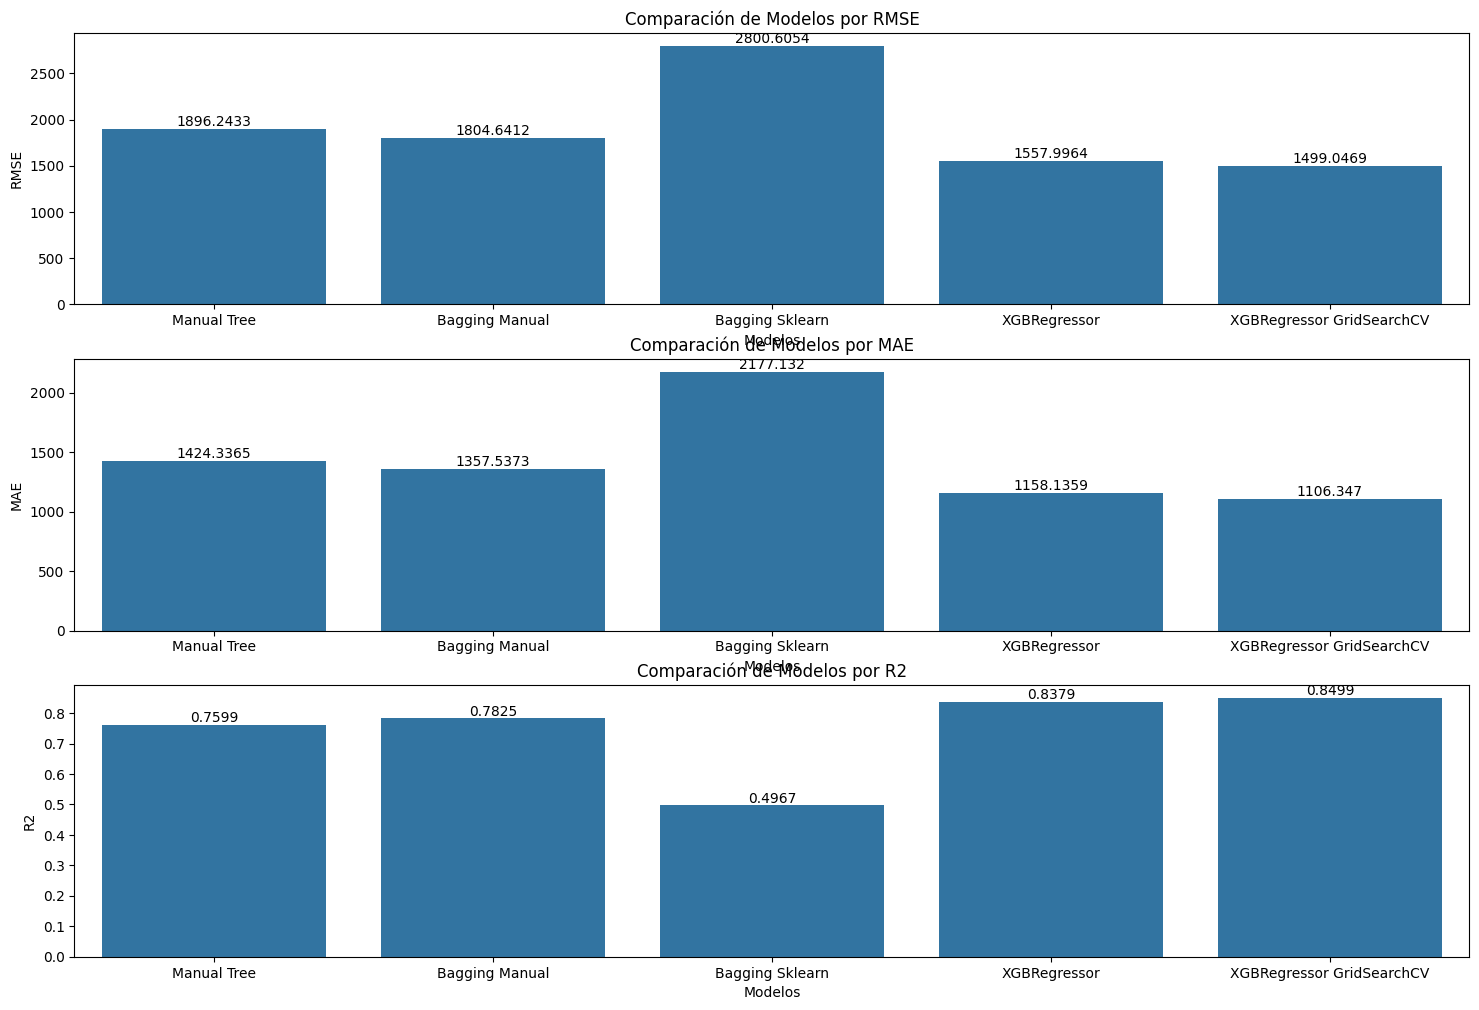

In [114]:
modelos = ["Manual Tree", "Bagging Manual", "Bagging Sklearn", "XGBRegressor", "XGBRegressor GridSearchCV"]
MSE = [MSETREE, MSE_bgm, MSE_bgl, MSE_XGBReg, MSE_XGBGridSearchCV]
RMSE = [np.sqrt(MSETREE), RMSE_bgm, RMSE_bgl, RMSE_XGBReg, RMSE_XGBGridSearchCV]
MAE = [mean_absolute_error(y_test, yPredict_Tree), MAE_bgm, MAE_bgl, MAE_XGBReg, MAE_XGBGridSearchCV]
R2 = [r2Tree, r2_bgm, r2_bgl, R2_XGBReg, R2_XGBGridSearchCV]

# Crear subplots
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

# Gráfico 1: Comparar modelos por RMSE
sns.barplot(x=modelos, y=RMSE, ax=axs[0])
axs[0].set_title('Comparación de Modelos por RMSE')
axs[0].set_xlabel('Modelos')
axs[0].set_ylabel('RMSE')
for i in range(len(modelos)):
    axs[0].text(i, RMSE[i], round(RMSE[i], 4), ha='center', va='bottom')

# Gráfico 2: Comparar modelos por MAE
sns.barplot(x=modelos, y=MAE, ax=axs[1])
axs[1].set_title('Comparación de Modelos por MAE')
axs[1].set_xlabel('Modelos')
axs[1].set_ylabel('MAE')
for i in range(len(modelos)):
    axs[1].text(i, MAE[i], round(MAE[i], 4), ha='center', va='bottom')

# Gráfico 3: Comparar modelos por R2
sns.barplot(x=modelos, y=R2, ax=axs[2])
axs[2].set_title('Comparación de Modelos por R2')
axs[2].set_xlabel('Modelos')
axs[2].set_ylabel('R2')
for i in range(len(modelos)):
    axs[2].text(i, R2[i], round(R2[i], 4), ha='center', va='bottom')